# Introduction - NMF
In this notebook, statistical analysis methods will be used to investigate the relationship between citation number and topics. More specifically, it is envised to perform research on if topic can be used to predict the citation. 
As always, the first step is to set up the environment and load functions. 

In [3]:
# set up the environment 
# Read the content of the setup script
setup_script = 'Setup/step4.py'

with open(setup_script, 'r') as file:
    setup_code = file.read()

# Execute the setup script
exec(setup_code)

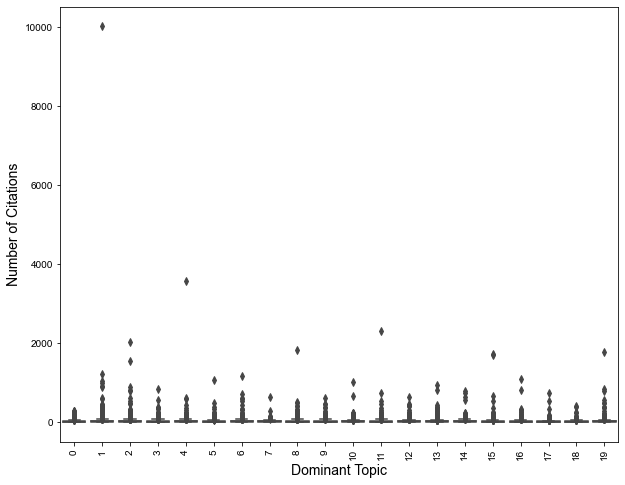

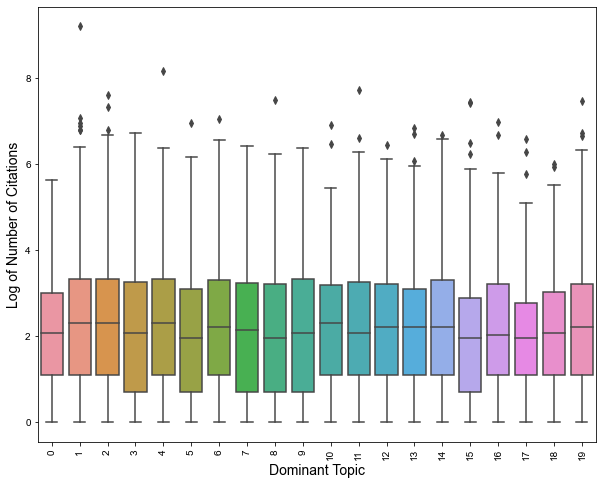

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Read the CSV file
file_path = 'ProcessedData/nmf_for_regression.csv'  # Replace with your file path
df = pd.read_csv(file_path)
plt.rcParams['font.family'] = 'Arial'

# Check if the necessary columns exist in the dataframe
if 'n_citation' in df.columns and 'dominant_topic' in df.columns:
    # Create the first box plot
    plt.figure(figsize=(10, 8))
    sns.boxplot(x='dominant_topic', y='n_citation', data=df)
    #plt.title('Box Plot of n_citation by dominant_topic')
    plt.xlabel('Dominant Topic',size='14')
    plt.ylabel('Number of Citations',size='14')
    plt.xticks(rotation=90)  # Rotate x labels for better readability
    plt.show()
    
    # Create a new column for the log of n_citation
    df['log_n_citation'] = np.log(df['n_citation'] + 1)  # Adding 1 to avoid log(0)
    
    # Create the second box plot for the log of n_citation
    plt.figure(figsize=(10, 8))
    sns.boxplot(x='dominant_topic', y='log_n_citation', data=df)
    #plt.title('Box Plot of Log(n_citation) by dominant_topic')
    plt.xlabel('Dominant Topic',size='14')
    plt.ylabel('Log of Number of Citations',size='14')
    plt.xticks(rotation=90)  # Rotate x labels for better readability
    plt.show()
else:
    print("The required columns 'n_citation' and 'dominant_topic' are not present in the CSV file.")

Each paper is assigned a dominant topic using either Latent Dirichlet Allocation (LDA) or Non-Negative Matrix Factorization (NMF). These dominant topics are then used to categorize the papers into 20 distinct groups. To investigate the differences in mean citation counts across these groups, we will perform a statistical test. The hypotheses for this test are as follows:

- **Null Hypothesis (H0)**: The mean citation count is the same for all groups.
- **Alternative Hypothesis (H1)**: The mean citation count differs among the groups.

We will use Analysis of Variance (ANOVA) to conduct this test.

In [1]:
import pickle

with open("ProcessedData/corpus.pkl", "rb") as f:
    corpus = pickle.load(f)

# Load the final object
with open("ProcessedData/final.pkl", "rb") as f:
    final = pickle.load(f)

In [4]:
# Read the CSV file
file_path = 'ProcessedData/nmf_for_regression.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

# Perform ANOVA
model = ols('n_citation ~ C(dominant_topic)', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Print the ANOVA table
print(anova_table)

                         sum_sq      df         F    PR(>F)
C(dominant_topic)  7.006843e+05    19.0  1.816288  0.016142
Residual           1.791229e+08  8822.0       NaN       NaN




These results indicate that there is  significant difference in the mean citation count among the different groups defined by the dominant topic.

Please note that the ANOVA test assumes the null hypothesis that the mean citation count is the same for all groups. 

However, one of the assumptions for ANOVA is that the data follows a normal distribution, which might not be the case here. The next step is to check the normality of the data. This can be done using normality tests such as the Shapiro-Wilk test, Q-Q plots, or the Kolmogorov-Smirnov test.

In [13]:
from scipy.stats import shapiro

# Perform Shapiro-Wilk test on the n_citation column
stat, p = shapiro(data['n_citation'])

# Print the results
print('Shapiro-Wilk Test:')
print(f'Statistic: {stat}, p-value: {p}')

Shapiro-Wilk Test:
Statistic: 0.13504594564437866, p-value: 0.0


c:\Users\inrus\anaconda3\envs\myenv\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


The Shapiro-Wilk test was used to assess the normality of the citation data. The test returned a very low statistic (0.135) and a p-value of 0.0, indicating that the citation data significantly deviates from a normal distribution.

Given this result, the normality assumption for ANOVA is violated. Therefore, we will consider the following two alternatives:

1. **Data Transformation**: Apply transformations to the data to achieve normality.
2. **Non-parametric Test**: Use a non-parametric test that does not assume normality, such as the Kruskal-Wallis test.

In [14]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols



# Apply a logarithmic transformation to the n_citation column
data['log_n_citation'] = np.log(data['n_citation'] + 1)

# Perform ANOVA on transformed data
model_log = ols('log_n_citation ~ C(dominant_topic)', data=data).fit()
anova_table_log = sm.stats.anova_lm(model_log, typ=2)

# Print the ANOVA table
print(anova_table_log)

                         sum_sq      df         F    PR(>F)
C(dominant_topic)     88.434349    19.0  2.118495  0.003081
Residual           19382.373770  8822.0       NaN       NaN


In [15]:
import pandas as pd
from scipy.stats import kruskal

# Perform Kruskal-Wallis H Test
groups = data.groupby('dominant_topic')['n_citation'].apply(list)
stat, p = kruskal(*groups)

# Print the results
print('Kruskal-Wallis H Test:')
print(f'Statistic: {stat}, p-value: {p}') 

Kruskal-Wallis H Test:
Statistic: 39.49312591588303, p-value: 0.003811886916578957


Having established that the mean citation counts among these groups are statistically significant, the next step is to use regression techniques for potential prediction. By applying regression analysis, we can model the relationship between dominant topics and citation counts, allowing us to predict citation counts based on the identified topics.

### Single Linear Regression Model

We begin with a single linear regression model where the number of citations serves as the dependent variable, and the topic loadings are the independent variables. This approach helps us understand how variations in the presence and strength of specific topics influence the number of citations an article receives.

The single linear regression model can be represented as:

𝑌=
𝛽
0
+
𝛽
1
𝑋
1
+
𝜖

Where:
- 𝑌 is the dependent variable representing the number of citations.
- 𝛽0 is the intercept.
- 𝛽1 is the coefficient for the independent variable 𝑋1, which represents the topic loadings.
- 𝜖 is the error term.

By fitting this model to our data, we aim to estimate the coefficients 𝛽0 and 𝛽1, which will provide insights into the strength and direction of the relationship between dominant topics and citation counts. 

### Model Evaluation

To assess the goodness-of-fit of our model, we will use metrics such as the R-squared value. The R-squared value indicates how well our independent variable (topic loadings) explains the variability in the dependent variable (citation counts). A higher R-squared value implies a better fit of the model to the data.

### Future Steps

This initial application of single linear regression sets the foundation for more complex models, such as multiple linear regression, which can incorporate multiple independent variables (various topic loadings) simultaneously. By progressively refining our models, we aim to enhance the accuracy and predictive power of our analysis, ultimately contributing to a deeper understanding of the factors driving citation counts in academic literature.

In [5]:
import statsmodels.api as sm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define a small constant to add to citations to avoid log(0) issues
epsilon = 1e-9
X = pd.get_dummies(data['dominant_topic'], drop_first=True)

y = np.log(data['n_citation']+epsilon)


# Split the data into training and testing sets using the index
train_indices, test_indices = train_test_split(data.index, test_size=0.2, random_state=42)

# Create training and testing sets
X_train, X_test = X.loc[train_indices], X.loc[test_indices]
y_train, y_test = y.loc[train_indices], y.loc[test_indices]

# Add a constant term to the independent variables
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the linear regression model on the training set
model = sm.OLS(y_train, X_train).fit()

# Print the model summary
print(model.summary())

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

                            OLS Regression Results                            
Dep. Variable:             n_citation   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.667
Date:                Sun, 04 Aug 2024   Prob (F-statistic):             0.0342
Time:                        20:11:47   Log-Likelihood:                -24876.
No. Observations:                7073   AIC:                         4.979e+04
Df Residuals:                    7053   BIC:                         4.993e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3868      0.473     -0.818      0.4



### Summary
Overall, the model demonstrates poor explanatory power, as many predictors do not significantly contribute to explaining the variation in citation counts.

## Regression with all topic loadings. 
Next, we perform the regression using all topic loadings instead of only the domiant topic. 
The result is still not satisfisfactory. We know already from preivous steps that the citation is not normal distributed. The linear relationship might not exisit. As such, we will furhter perfrom random foreast and deep learning technicals which could potentially take into account any non-linear relationships. Given the size of the avaiable data, they could be better alternatives. 


In [22]:
import statsmodels.api as sm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'data' is your DataFrame
# Define the dependent variable
y = np.log(data['n_citation']+epsilon)


# Define the independent variables
X = data[['topic0', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6', 'topic7', 'topic8', 'topic9', 'topic10', 'topic11', 'topic12', 'topic13', 'topic14', 'topic15', 'topic16', 'topic17', 'topic18', 'topic19']]



# Create training and testing sets
X_train, X_test = X.loc[train_indices], X.loc[test_indices]
y_train, y_test = y.loc[train_indices], y.loc[test_indices]

# Add a constant term to the independent variables
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the linear regression model on the training set
model = sm.OLS(y_train, X_train).fit()

# Print the model summary
print(model.summary())

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')




                            OLS Regression Results                            
Dep. Variable:             n_citation   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     3.169
Date:                Sun, 04 Aug 2024   Prob (F-statistic):           2.26e-06
Time:                        19:16:01   Log-Likelihood:                -24860.
No. Observations:                7073   AIC:                         4.976e+04
Df Residuals:                    7052   BIC:                         4.991e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.8585     18.466      0.588      0.5

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'data' is your DataFrame
# Define the dependent variable
y = np.log(data['n_citation']+epsilon)

# Define the independent variables
X = data[['topic0', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6', 'topic7', 'topic8', 'topic9', 'topic10', 'topic11', 'topic12', 'topic13', 'topic14', 'topic15', 'topic16', 'topic17', 'topic18', 'topic19']]

# Split the data into training and testing sets
X_train, X_test = X.loc[train_indices], X.loc[test_indices]
y_train, y_test = y.loc[train_indices], y.loc[test_indices]

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 65.71481762559692
R-squared: -0.05110474757363437


A simple forward neural network was trained to create a model capable of predicting the number of citations based on topic loadings. However, the quality of the model is not satisfactory. This outcome further demonstrates that topic loadings cannot be reliably used for citation prediction.

In [7]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define the dependent variable
y = np.log(data['n_citation']+epsilon)

# Define the independent variables
X = data[['topic0', 'topic1', 'topic2', 'topic3', 'topic4', 'topic5', 'topic6', 'topic7', 'topic8', 'topic9', 'topic10', 'topic11', 'topic12', 'topic13', 'topic14', 'topic15', 'topic16', 'topic17', 'topic18', 'topic19']]

# Split the data into training and testing sets
X_train, X_test = X.loc[train_indices], X.loc[test_indices]
y_train, y_test = y.loc[train_indices], y.loc[test_indices]


# Normalize the data
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=1)

# Make predictions
y_pred = model.predict(X_test).flatten()

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Epoch 1/100
177/177 [==============================] - 0s 1ms/step - loss: 66.7737 - val_loss: 67.7038
Epoch 2/100
177/177 [==============================] - 0s 683us/step - loss: 66.3410 - val_loss: 67.4679
Epoch 3/100
177/177 [==============================] - 0s 716us/step - loss: 66.1814 - val_loss: 67.3597
Epoch 4/100
177/177 [==============================] - 0s 886us/step - loss: 66.0160 - val_loss: 67.1728
Epoch 5/100
177/177 [==============================] - 0s 731us/step - loss: 65.8453 - val_loss: 67.1238
Epoch 6/100
177/177 [==============================] - 0s 705us/step - loss: 65.7150 - val_loss: 67.0136
Epoch 7/100
177/177 [==============================] - 0s 722us/step - loss: 65.5602 - val_loss: 66.9622
Epoch 8/100
177/177 [==============================] - 0s 775us/step - loss: 65.4559 - val_loss: 66.9657
Epoch 9/100
177/177 [==============================] - 0s 796us/step - loss: 65.3114 - val_loss: 67.0818
Epoch 10/100
177/177 [==============================] - 0

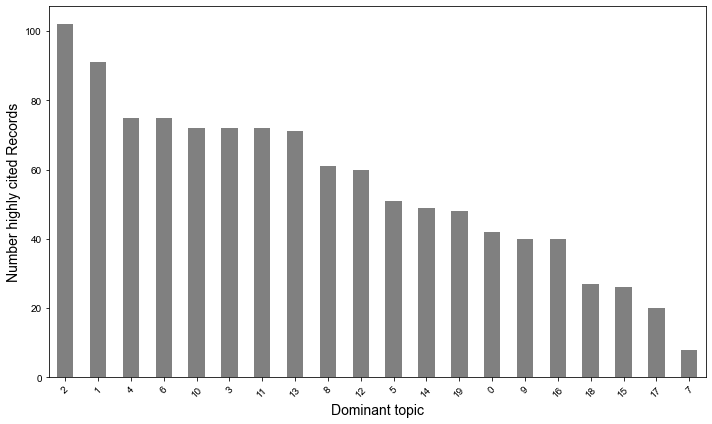

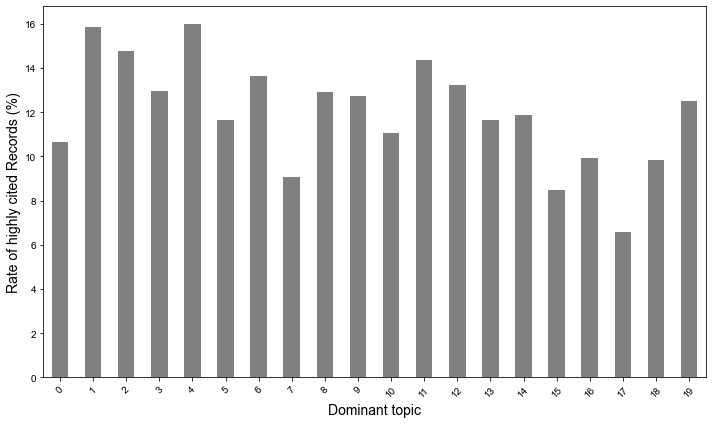

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('ProcessedData/nmf_for_regression.csv')

# Treat 'dominant_topic' as categorical data
#df['dominant_topic'] = df['dominant_topic'].astype('category')

# Filter records where 'n_citation' is greater than 50
df_filtered = df[df['n_citation'] > 50]

# 1. Number of records by 'dominant_topic'
topic_counts = df_filtered['dominant_topic'].value_counts()
plt.rcParams['font.family'] = 'Arial'
# Plotting the number of records by 'dominant_topic'
plt.figure(figsize=(10, 6))
topic_counts.plot(kind='bar',color='gray')
#plt.title('Number of Records by Dominant Topic where n_citation > 100')
plt.xlabel('Dominant topic',size='14')
plt.ylabel('Number highly cited Records',size='14')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Rate of records for each 'dominant_topic'
total_counts = df['dominant_topic'].value_counts()
rate_of_records = (topic_counts / total_counts) * 100

# Plotting the rate of records by 'dominant_topic'
plt.figure(figsize=(10, 6))
rate_of_records.plot(kind='bar',color='gray')
#plt.title('Rate of Records by Dominant Topic where n_citation > 100')
plt.xlabel('Dominant topic',size='14')
plt.ylabel('Rate of highly cited Records (%)',size='14')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
